In [1]:
from pax import core, utils, datastructure, simulation, units
from pax.plugins.io.WaveformSimulator import uniform_circle_rv
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
import numpy as np

In [4]:
### User sets values here
# for plotting
date = 150730
save_on=False
folder_loc = "plots/"

# for savind and loading data
load_data = False
save_data = False

#for simulations
n_pe = 100
n_trials = 1000

# Save plots options
def save_plot(title):
    plt.savefig(folder_loc +"pdf/" + str(date) + title +"%s_trials.pdf" % (n_trials), format='pdf')
    plt.savefig(folder_loc + str(date) + title +"%s_trials.png" % (n_trials), dpi=300)


In [2]:
# Load the posrec plugins
plugins_to_test = [
    ('MaxPMT', 'PosRecMaxPMT'),
    ('PosSimple', 'PosRecWeightedSum'),
    ('NeuralNet', 'PosRecNeuralNet'),
    ('PosRecChiSquareGamma', 'PosRecChiSquareGamma'),
]
mypax = core.Processor(config_names=['XENON100'], config_dict={
    'pax': {
            'plugin_group_names': ['test'],
            'test':               ["%s.%s" % (a, b) for a, b in plugins_to_test],},
    'PosRecChiSquareGamma.PosRecChiSquareGamma': {
            'seed_from_neural_net': False,
    }
})
sim = mypax.simulator
posrec_plugin = {b: mypax.get_plugin_by_name(b) for a,b in plugins_to_test}

In [3]:
lcemap = utils.Vector2DGridMap(utils.data_file_name('s2_xy_lce_map_XENON100_Xerawdp0.4.5.json.gz'))

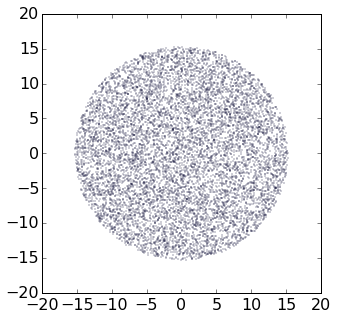

In [5]:
# Check that sampling algorithm is correct
detector_radius = sim.config['tpc_radius']
xs, ys = uniform_circle_rv(detector_radius, 10000)
plt.figure(figsize=(5,5))
plt.scatter(xs, ys, s=1, edgecolor=None, alpha=0.2)
plt.show()

In [6]:
n_pe = 1300
n_trials = int(4e4)

n_top = n_pe * 0.53
rps = {}
differences = {}

def euclideandifference(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

# Make sure same PMTs are dead as Neural Net expects
# Well, "PMT 0" is also dead :-)
dead_pmts = [0, 9, 12, 39, 58]

xs, ys = uniform_circle_rv(detector_radius, n_trials)

# Cap hitpattern at "9k pe / channel" (adjusted for gain variations) to simulate saturation
# 9k is what Sander found when studying saturation 
max_pe_per_ch = np.array([9e3 / max(1e-9, sim.config['gains'][ch] / 2e6)
                          for ch in range(sim.config['n_channels'])])

for sample_i in tqdm(range(n_trials)):
    x = xs[sample_i]
    y = ys[sample_i]

    ph_per_ch = simulation.distribute_photons_by_lcemap(
        photon_timings=np.ones(n_top), 
        channels=[ch for ch in sim.config['channels_top'] 
                     if not ch in dead_pmts],
        lce_map=lcemap,
        coordinate_tuple=(x, y)
    )
    hitp = [len(ph_per_ch.get(ch, []))
            for ch in range(sim.config['n_channels'])]
    
    hitp = np.clip(hitp, 0, max_pe_per_ch)
    
    e = datastructure.Event.empty_event()
    e.peaks.append(datastructure.Peak({
        'left':  5,
        'right': 9,
        'type':  'S2',
        'detector':  'tpc',
        'area_per_channel': hitp}))

    # Run posrec plugins, collect results
    for pp_name, pp in posrec_plugin.items():
        differences[pp_name] = differences.get(pp_name, [])
        rps[pp_name] = rps.get(pp_name, [])
        e = pp.transform_event(e)
        for peak in e.peaks:
            rp = peak.reconstructed_positions[-1]
            if not rp.algorithm == pp_name:
                raise ValueError(rp.algorithm, pp_name)
            rps[pp_name].append((rp.x, rp.y))
            differences[pp_name].append(
                euclideandifference(rp.x, rp.y, x, y))

# Convert position list of tuples to numpy array
for pp_name, pp in posrec_plugin.items():            
    rps[pp_name] = np.array(rps[pp_name])

In [7]:
### Save data to file
if (load_data == False & save_data==True):
    for pp_name, pp in posrec_plugin.items():  
        np.savez(str(date) + "_datafile_" + str(n_pe) + "pe_" + str(n_trials) +"trials_" + pp_name + 'sat9k',
             xs=xs,ys=ys, pp_name=rps[pp_name])
# To see how to load data look at numpy savez

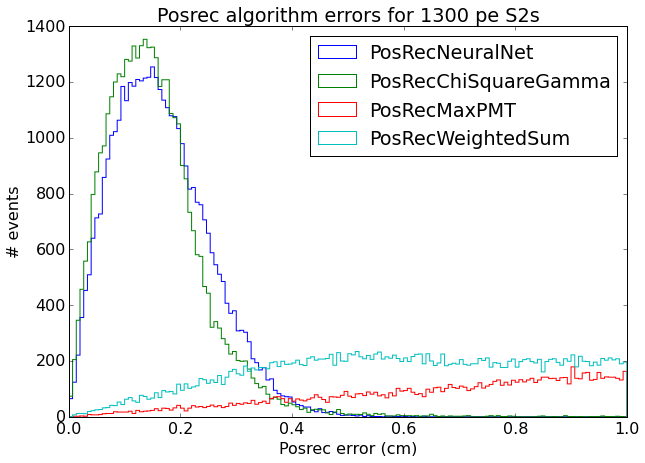

In [8]:
plt.figure(figsize=(10, 7))
for pp_name, pp in posrec_plugin.items():
    plt.hist(differences[pp_name], bins=150, range=(0, 1), histtype='step', label=pp_name)
plt.legend(loc='upper right')
plt.xlabel('Posrec error (cm)')
plt.ylabel('# events')
title = 'Posrec algorithm errors for %d pe S2s' % n_pe
plt.title(title)
if(save_on == True):
    save_plot(title)
plt.show()

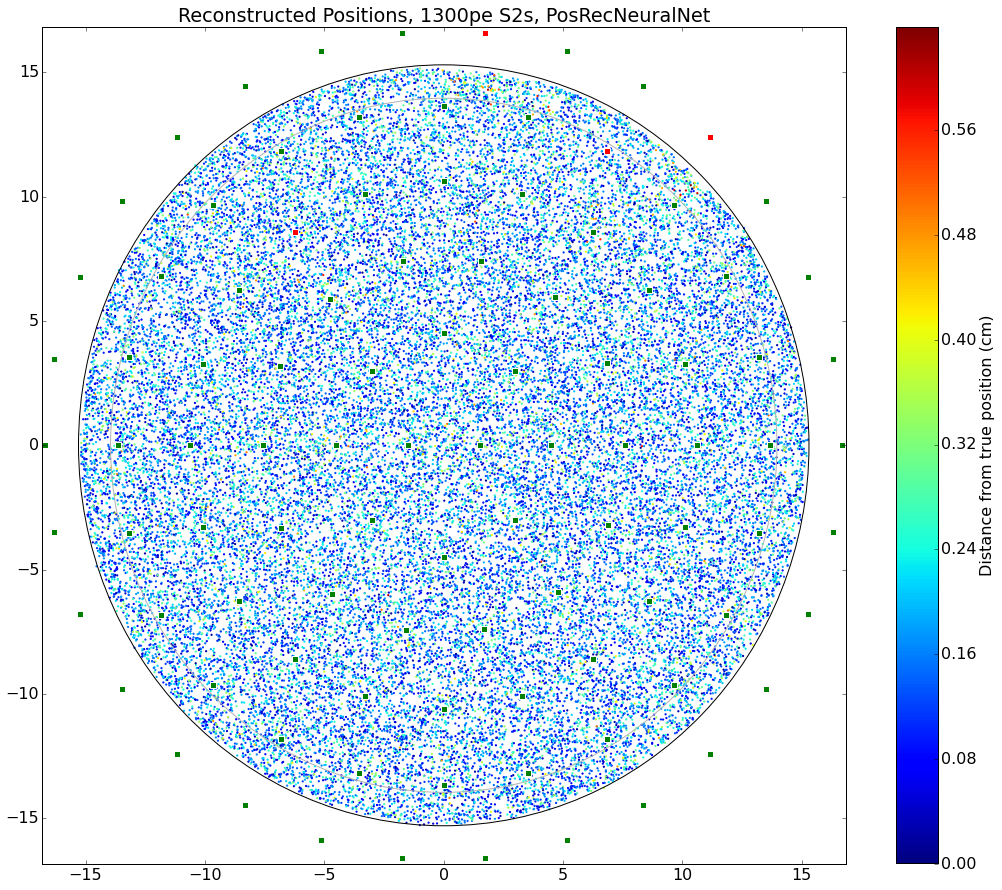

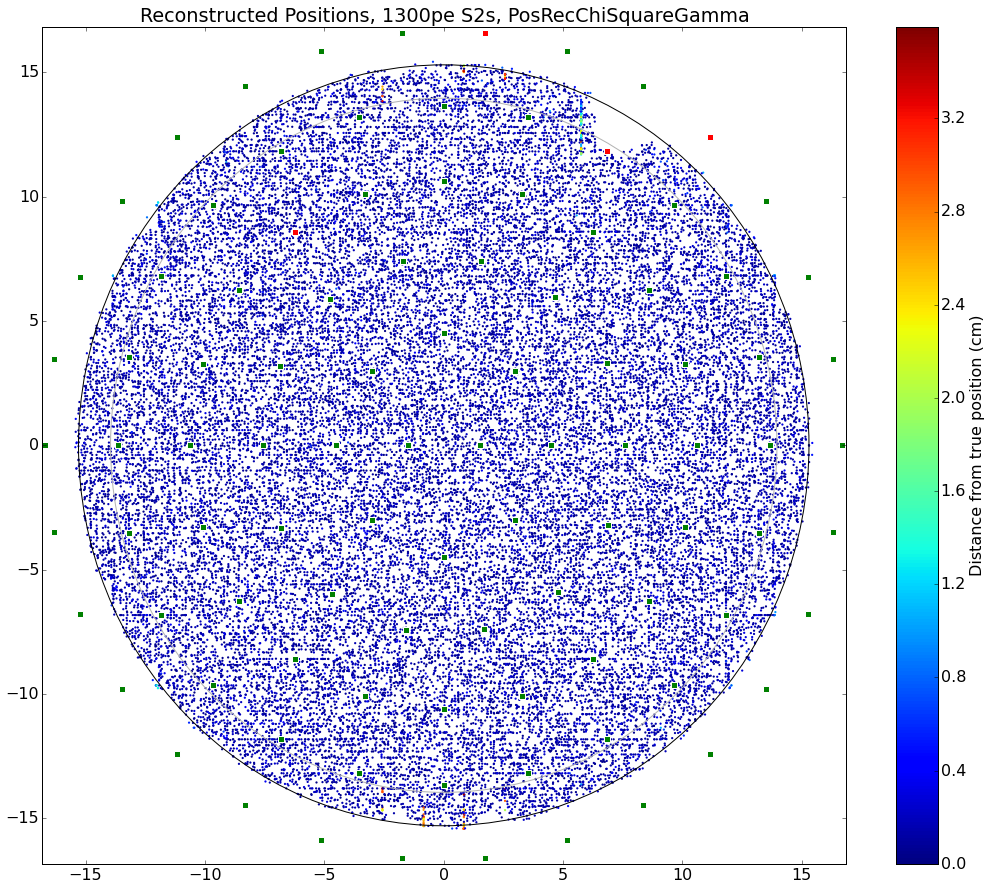

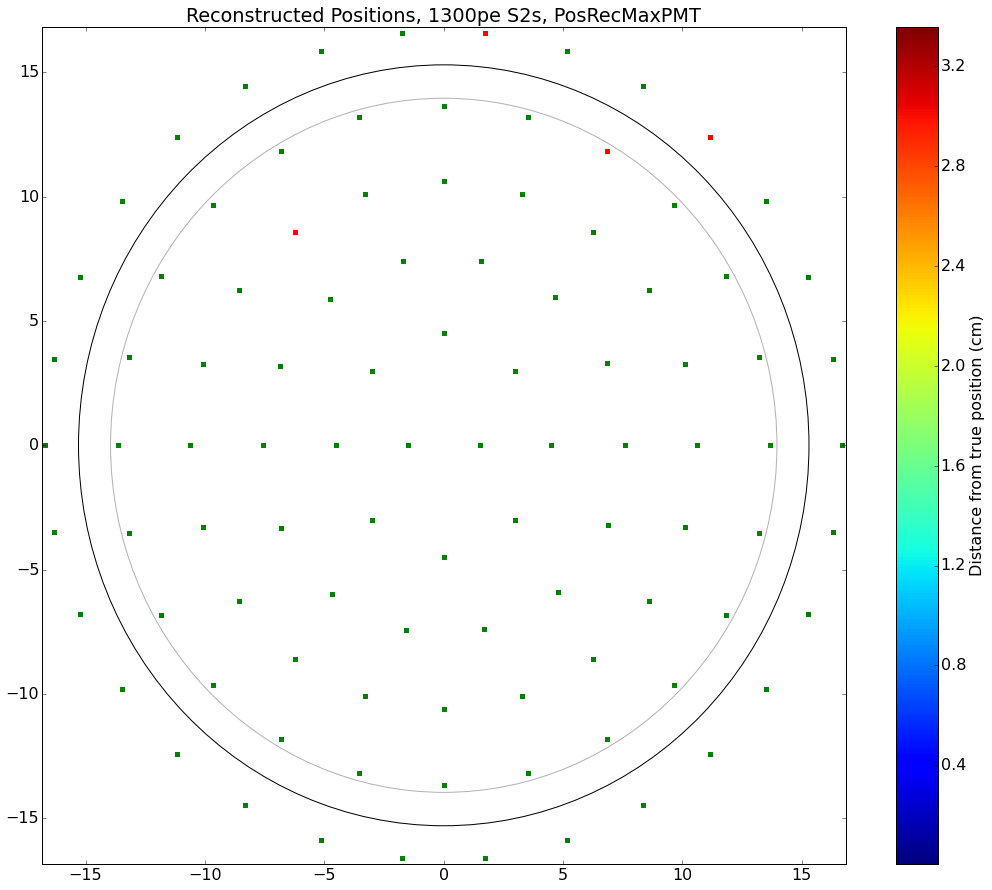

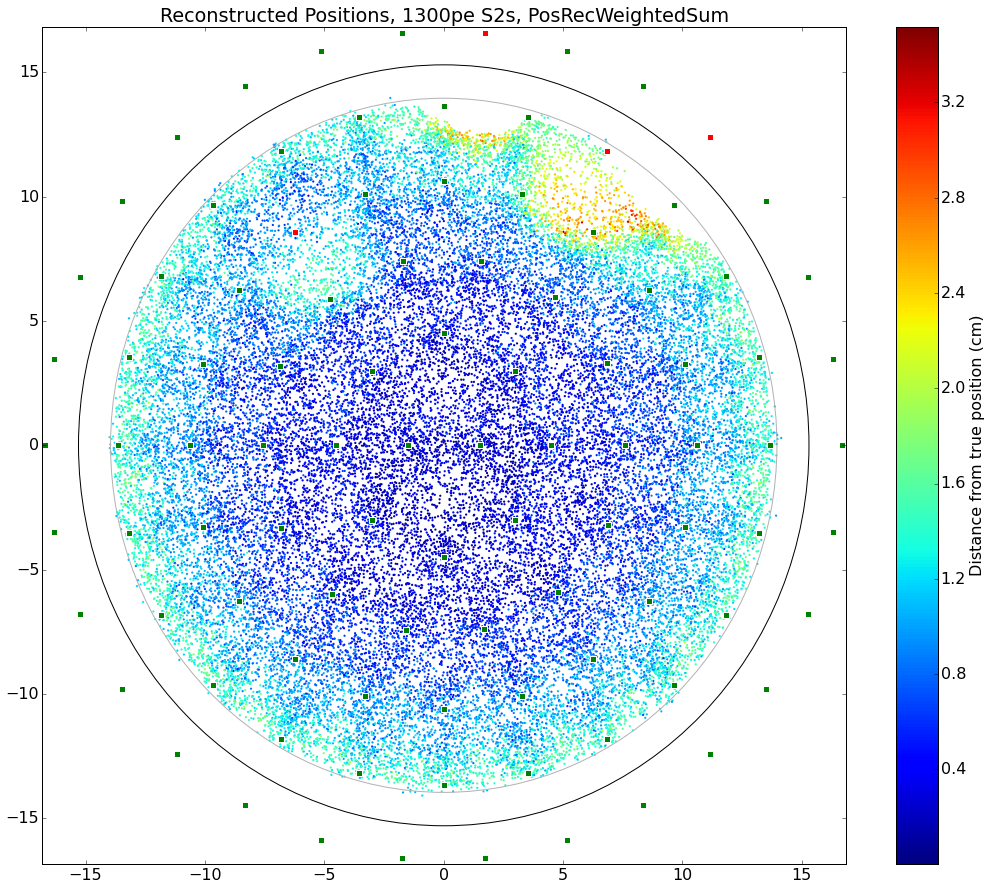

In [9]:
# Fiducial volume from xenon:xenon100:analysis:run10:fv, function above fig 3
fiducial_volume_radius = np.sqrt(19481*units.mm**2)

size_multiplier = 1.5

def plot_pmts(pmt_range, color, marker='x', s=20):
    plt.scatter([sim.config['pmt_locations'][i]['x'] for i in pmt_range], 
                [sim.config['pmt_locations'][i]['y'] for i in pmt_range],
                marker='s', s=s, facecolor=color, edgecolors='white')

def plot_top_array():
    plot_pmts([ch for ch in sim.config['channels_top'] if ch in dead_pmts and ch != 0],
              s=40, color='red')
    plot_pmts([ch for ch in sim.config['channels_top'] if ch not in dead_pmts],
              s=40, color='green')

def plot_detector_radius():
    plt.xlim((-1.1*detector_radius, 1.1*detector_radius))
    plt.ylim((-1.1*detector_radius, 1.1*detector_radius))

    plt.gca().add_artist(plt.Circle((0,0), 
                                    detector_radius, 
                                    edgecolor='black', 
                                    fill=None))
    plt.gca().add_artist(plt.Circle((0,0), 
                                    fiducial_volume_radius, 
                                    edgecolor='0.7',
                                    fill=None))

for pp_name in  posrec_plugin.keys():
    plt.figure(figsize=(12*size_multiplier,10*size_multiplier))
    plt.scatter(rps[pp_name][:,0], rps[pp_name][:,1],
                c=differences[pp_name], marker='.', edgecolors='none')
    plt.colorbar(label='Distance from true position (cm)')
    plot_detector_radius()
    plot_top_array()
    title = 'Reconstructed Positions, %dpe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    if(save_on == True):
        save_plot(title)
    plt.show()

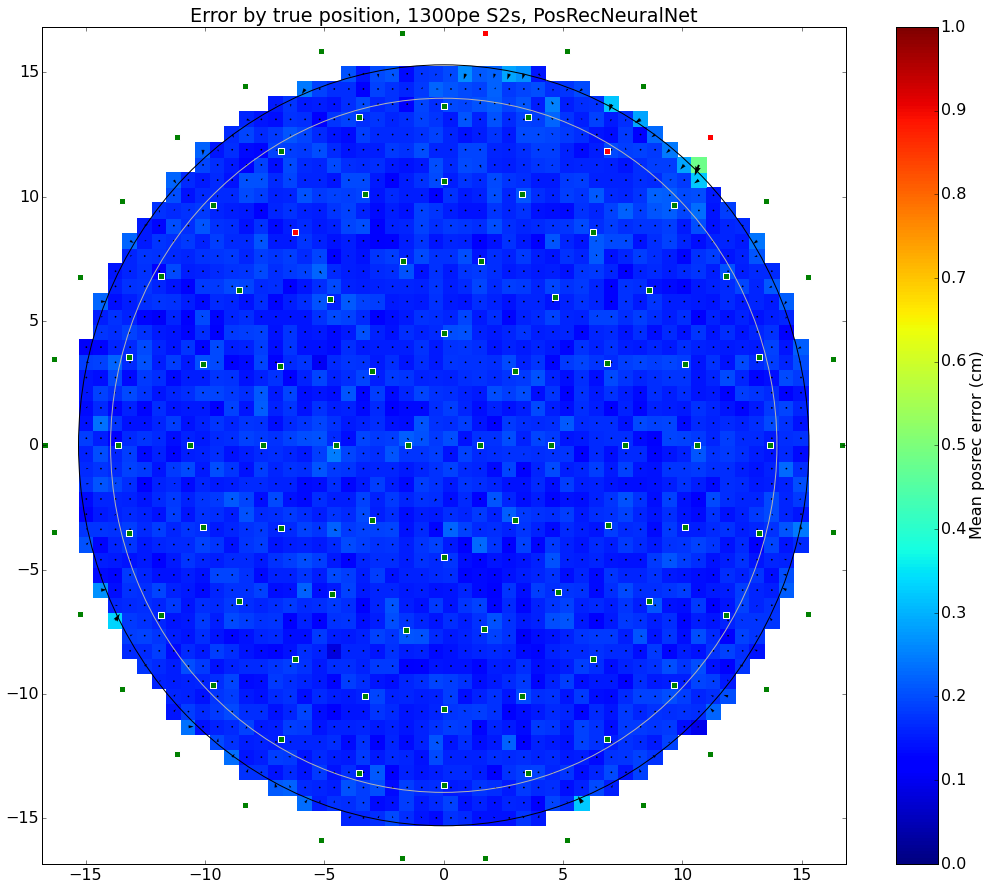

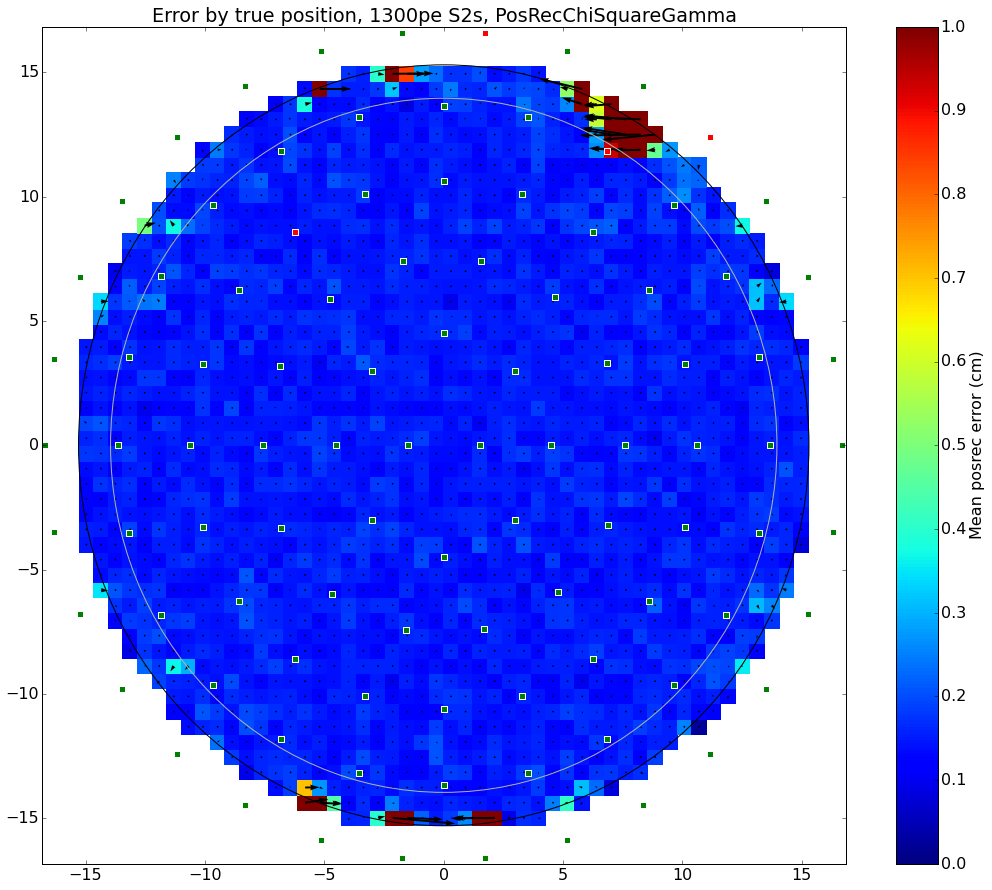

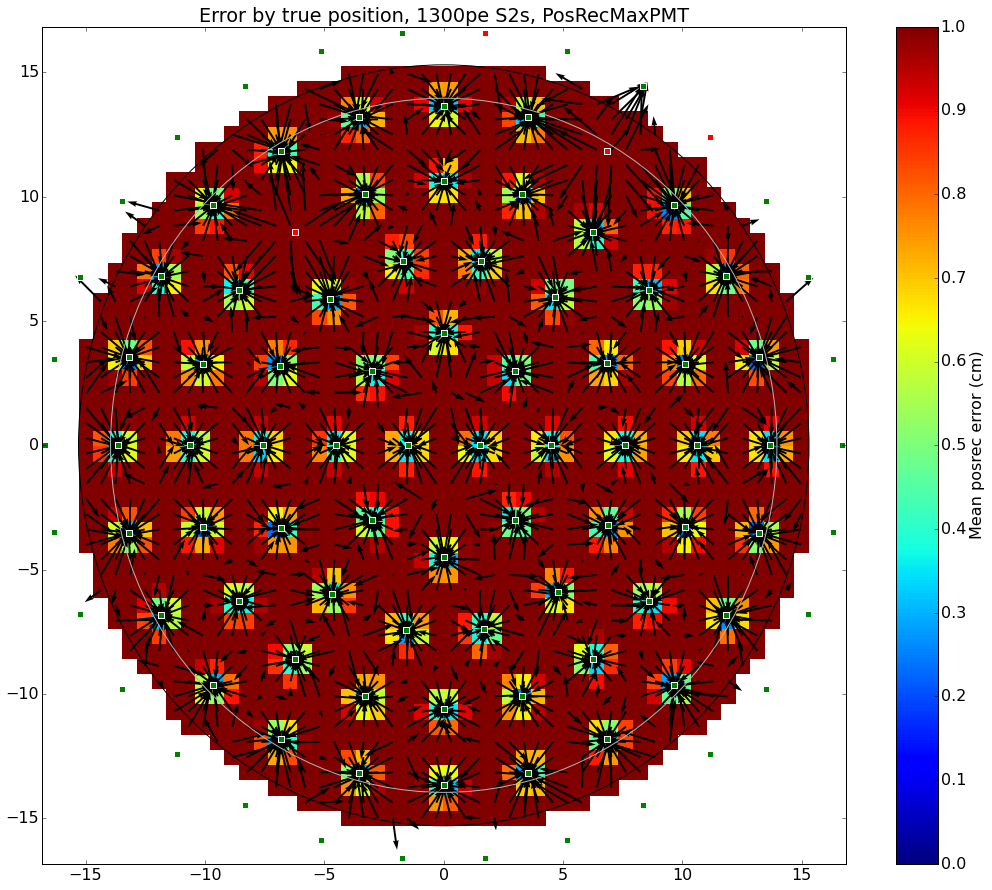

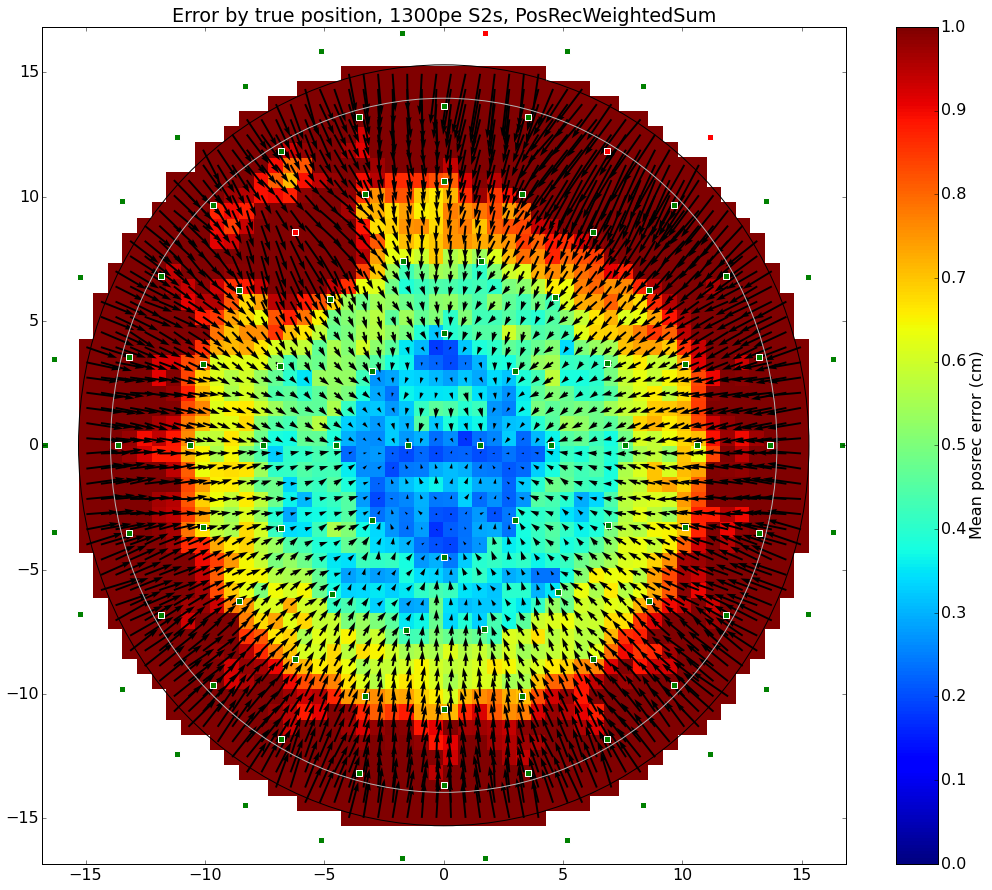

In [10]:
from scipy.stats import binned_statistic_2d
import numpy.ma as ma
import matplotlib.cm as cm

def bin_centers(bin_edges):
    return 0.5*(bin_edges[1:] + bin_edges[:-1])

def twod_stat_plot(x, y, z, statistic='mean', bins=10, range=None, vrange=None, cblabel=None):
    if vrange is None:
        vrange = (None, None)
    result, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        x, y, z,
        bins=bins,
        statistic=statistic,
        range=range,
    )
    xx, yy = np.meshgrid(xbinedges, ybinedges)    

    Zm = ma.masked_where(np.isnan(result),result)
    plt.figure(figsize=(size_multiplier*12, size_multiplier*10))
    plt.pcolormesh(xx, yy, Zm, vmin=vrange[0], vmax=vrange[1], 
                   #cmap=cm.hot
                  )
    plt.colorbar(label=cblabel)

for pp_name in  posrec_plugin.keys():
    bins = 50
    
    twod_stat_plot(ys, xs, differences[pp_name],
                   bins=bins, vrange=(0, 1),                   
                   cblabel='Mean posrec error (cm)')
    
    twod_difs = rps[pp_name] - np.array([xs, ys]).T

    x_bias, _, _, _ = binned_statistic_2d(
        xs, ys, twod_difs[:,0],
        bins=bins,
        statistic='mean',
    )
    y_bias, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        xs, ys, twod_difs[:,1],
        bins=bins,
        statistic='mean',
    )
    
    xx_center, yy_center = np.meshgrid(bin_centers(xbinedges), bin_centers(ybinedges))    
    xx, yy = np.meshgrid(xbinedges, ybinedges)    
    
    plt.quiver(yy_center, xx_center, x_bias, y_bias, 
               angles='xy', scale_units='xy', scale=1, pivot='tail')
    
    plot_top_array()
    plot_detector_radius() 
    title = 'Error by true position, %dpe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    if(save_on == True):
        save_plot(title)

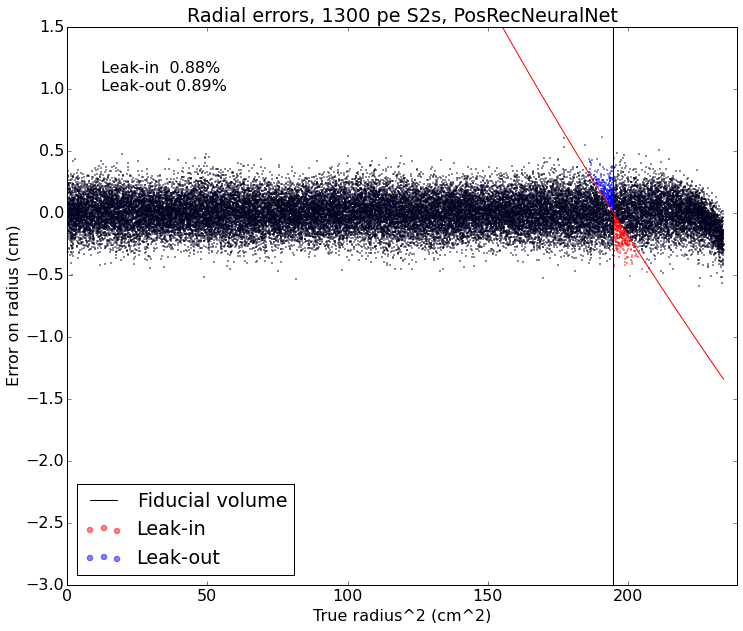

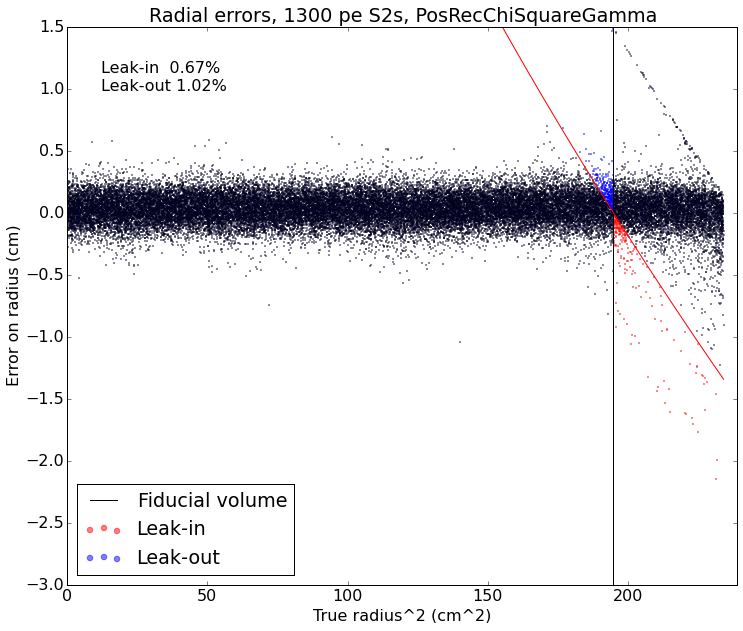

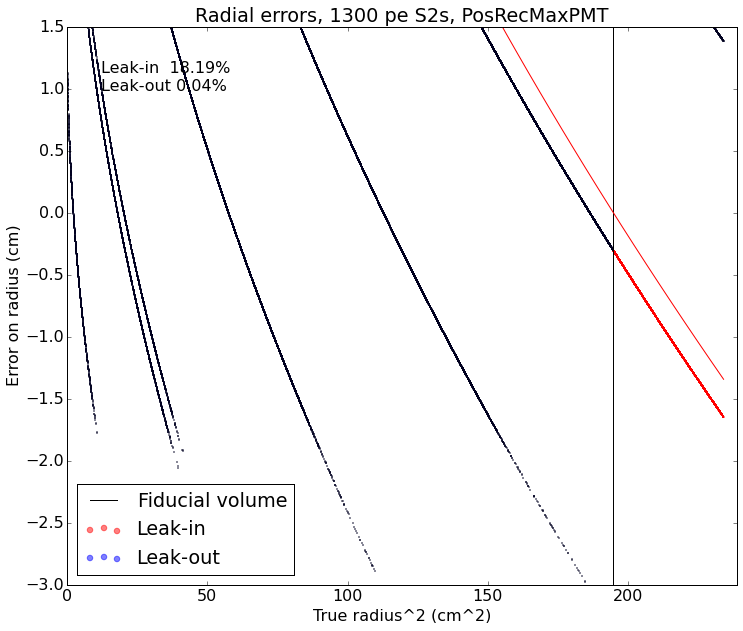

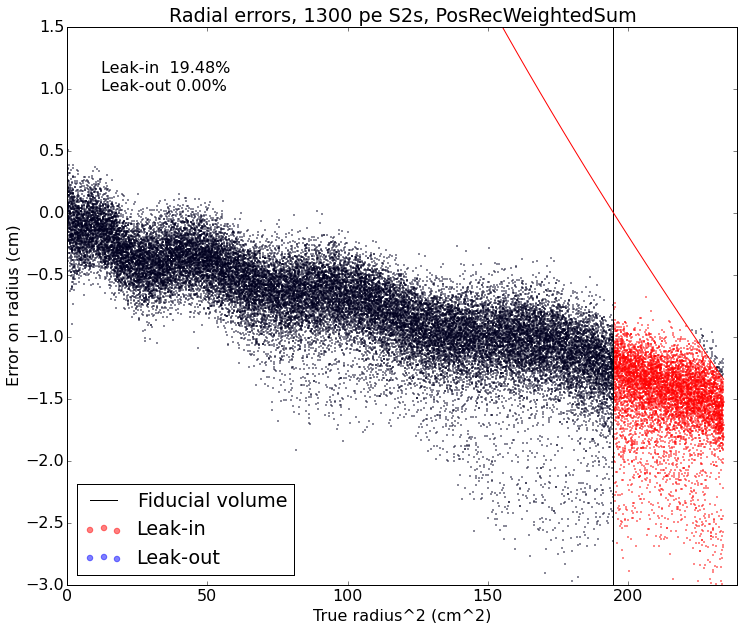

In [11]:
for pp_name in  posrec_plugin.keys():
    
    rs = np.sqrt(np.array(xs)**2+np.array(ys)**2)
    rs_rec = np.sqrt(rps[pp_name][:,0]**2 + rps[pp_name][:,1]**2)
    radial_errors = rs_rec - rs
    
    plt.figure(figsize=(12, 10))
    
    leak_in =  (rs > fiducial_volume_radius) & (rs_rec < fiducial_volume_radius)
    leak_out = (rs < fiducial_volume_radius) & (rs_rec > fiducial_volume_radius)
    
    plt.scatter(rs[leak_in]**2, 
                radial_errors[leak_in], 
                s=1, alpha=0.5, label='Leak-in', color='red')
    
    plt.scatter(rs[leak_out]**2, 
                radial_errors[leak_out], 
                s=1, alpha=0.5, label='Leak-out', color='blue')
    
    plt.scatter(rs[True ^ (leak_out | leak_in)]**2, 
                radial_errors[True ^ (leak_out | leak_in)], 
                s=1, alpha=0.5)
    
    message = "Leak-in  %0.2f%%\nLeak-out %0.2f%%" % (
            100 * len(np.where(leak_in)[0])/len(np.where(rs < fiducial_volume_radius)[0]),
            100 * len(np.where(leak_out)[0])/len(np.where(rs < fiducial_volume_radius)[0]))
    plt.text(0.05, 0.91, message,
         horizontalalignment='left',
         verticalalignment='center',
         transform = plt.gca().transAxes)
                                                    
    plt.axvline(fiducial_volume_radius**2, color='black', 
                label='Fiducial volume')

    rarg = np.linspace(0, detector_radius, 100)
    error_for_fv = fiducial_volume_radius - rarg    
    plt.plot(rarg**2, error_for_fv, color='red')
    
    plt.xlim(0, 1.02*detector_radius**2)
    plt.ylim(-3, 1.5)
    plt.xlabel('True radius^2 (cm^2)')
    plt.ylabel('Error on radius (cm)')
    leg = plt.legend(loc='lower left')
    for l in leg.legendHandles:
        l._sizes = [30]
    title = 'Radial errors, %d pe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    if(save_on == True):
        save_plot(title)
    plt.show()

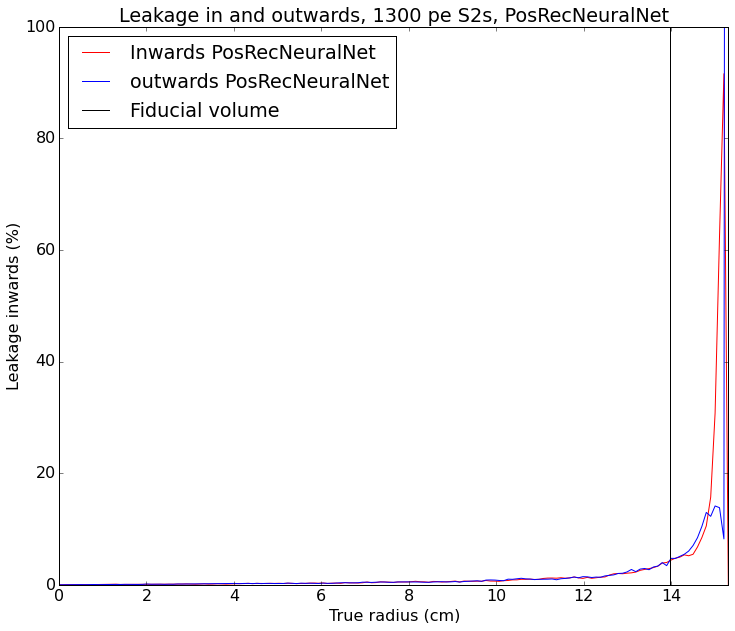

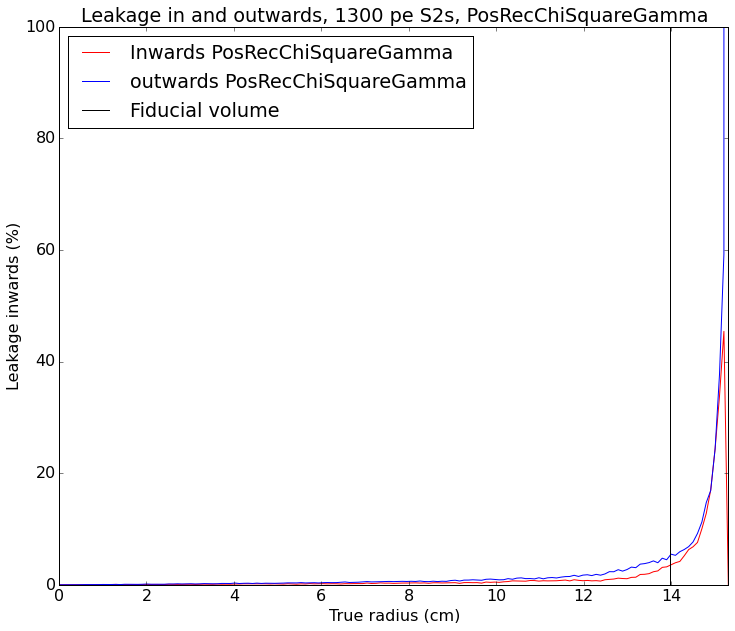

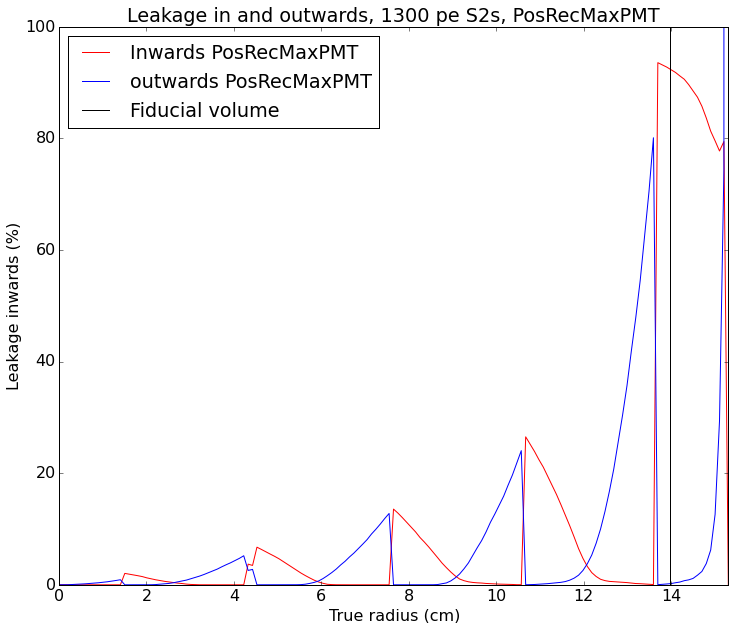

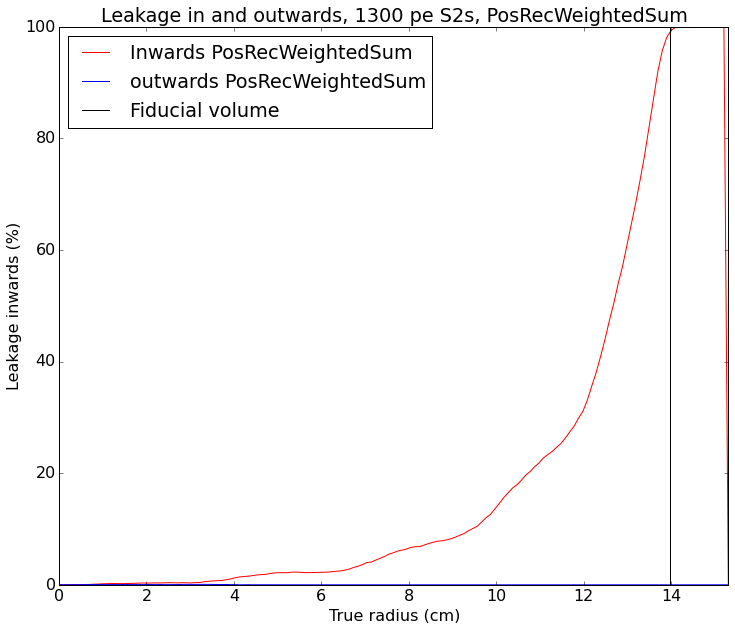

In [13]:
def leaking_in(rs,rs_rec,r,inwards = True):
    leakage_in = []
    leakage_out = []
    for radius in r:
        # if real is bigger than the radius and the reconstructed is smaller
        leak_in =  (rs > radius) & (rs_rec < radius)
        leak_out = (rs < radius) & (rs_rec > radius)
        # Do not devide by 0
        if len(np.where(rs > radius)[0])==0:
            leakage_in.append(100 * len(np.where(leak_in)[0]))
            leakage_out.append(100 * len(np.where(leak_out)[0]))
        else:
            leakage_in.append(100 * len(np.where(leak_in)[0])/len(np.where(rs > radius)[0]))
            leakage_out.append(100 * len(np.where(leak_out)[0])/len(np.where(rs > radius)[0]))
    return leakage_in,leakage_out


for pp_name in  posrec_plugin.keys():
    
    rs = np.sqrt(np.array(xs)**2+np.array(ys)**2)
    rs_rec = np.sqrt(rps[pp_name][:,0]**2 + rps[pp_name][:,1]**2)
    radial_errors = rs_rec - rs
    
    plt.figure(figsize=(12, 10))
    
    r = np.linspace(0, detector_radius, 153)
    inwards, outwards = leaking_in(rs,rs_rec,r)
    plt.plot(r,inwards, label = 'Inwards %s' % pp_name, c = 'red')
    plt.plot(r,outwards, label = 'outwards %s' % pp_name, c= 'blue')
    
    plt.axvline(fiducial_volume_radius, color='black', 
            label='Fiducial volume')

    plt.xlabel('True radius (cm)')
    plt.ylabel('Leakage inwards (%)')
    plt.ylim(0,100)
    plt.xlim(0,detector_radius)
    leg = plt.legend(loc='upper left')
    for l in leg.legendHandles:
        l._sizes = [30]
    title = 'Leakage in and outwards, %d pe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    if(save_on == True):
        save_plot(title)
    plt.show()
    